In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from sklearn.linear_model import LinearRegression, LassoCV, ElasticNetCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.utils import shuffle
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint as sp_randint

In [2]:
train_data = pd.read_excel('churn_HW2.xlsx', sheet_name  = 'training data set')
test_data = pd.read_excel('churn_HW2.xlsx', sheet_name  = 'test data set' )
train_test_df = pd.concat([train_data, test_data], axis = 0)

## Preprocessing

In [3]:
train_test_df.isnull().sum()

custid        20
retained       0
created       20
firstorder    20
lastorder     20
esent          0
eopenrate      0
eclickrate     0
avgorder       0
ordfreq        0
paperless      0
refill         0
doorstep       0
train          0
favday         0
city           0
dtype: int64

In [4]:
train_test_df = train_test_df.dropna(axis=0, how='any')

In [5]:
train_test_df = train_test_df[train_test_df['lastorder'] != '1/0/00']
train_test_df = train_test_df[train_test_df['lastorder'] != '1904-01-01']
refined_df = train_test_df[train_test_df['lastorder'] != datetime.time(0, 0)]

In [6]:
refined_df.shape

(30747, 16)

In [7]:
refined_df['created'] = pd.DatetimeIndex(refined_df['created'])
refined_df['firstorder'] = pd.DatetimeIndex(refined_df['firstorder'])
refined_df['lastorder'] = pd.DatetimeIndex(refined_df['lastorder'])

C:\Users\seong\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\seong\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\seong\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

In [8]:
city_dummies = pd.get_dummies(refined_df['city'], prefix='city')
city_dummies.drop(city_dummies.columns[0], axis=1, inplace=True)
refined_df = pd.concat([refined_df, city_dummies], axis = 1)

In [9]:
favday_dumies = pd.get_dummies(refined_df['favday'], prefix = 'favday')
favday_dumies.drop(favday_dumies.columns[0], axis=1, inplace=True)
refined_df = pd.concat([refined_df, favday_dumies], axis = 1)

In [10]:
refined_df['order_duration'] = refined_df['lastorder'] - refined_df['firstorder'] 
refined_df['order_duration'] = refined_df['order_duration']/pd.Timedelta(1, unit='d')
refined_df['recency'] = refined_df['lastorder'].transform(lambda x: pd.qcut(x, 5, labels=range(1,6)))

## Model Selection

In [17]:
final_train_df = refined_df[refined_df['train'] == 1]
final_test_df = refined_df[refined_df['train'] == 0]

In [18]:
final_train_df.columns

Index(['custid', 'retained', 'created', 'firstorder', 'lastorder', 'esent',
       'eopenrate', 'eclickrate', 'avgorder', 'ordfreq', 'paperless', 'refill',
       'doorstep', 'train', 'favday', 'city', 'city_CHO', 'city_DCX',
       'city_RIC', 'favday_Monday', 'favday_Saturday', 'favday_Sunday',
       'favday_Thursday', 'favday_Tuesday', 'favday_Wednesday',
       'order_duration', 'recency'],
      dtype='object')

In [19]:
X_train = final_train_df[['esent', 'eopenrate', 'eclickrate', 'avgorder', 'ordfreq', 'paperless', 'refill', 'doorstep', 'city_CHO', 'city_DCX', 'city_RIC', 'order_duration', 'recency', 'favday_Monday', 'favday_Saturday', 'favday_Sunday', 'favday_Thursday', 'favday_Tuesday', 'favday_Wednesday']]
X_test = final_test_df[['esent', 'eopenrate', 'eclickrate', 'avgorder', 'ordfreq', 'paperless', 'refill', 'doorstep', 'city_CHO', 'city_DCX', 'city_RIC', 'order_duration', 'recency', 'favday_Monday', 'favday_Saturday', 'favday_Sunday', 'favday_Thursday', 'favday_Tuesday', 'favday_Wednesday']]
y_train = final_train_df['retained']
y_test = final_test_df['retained']

In [20]:
inner_n_folds = 5

## LASSO
lasso_tscv_inner_generator = TimeSeriesSplit(n_splits = inner_n_folds).split(X_train)
lasso_clf = LassoCV(max_iter = 10000, cv = lasso_tscv_inner_generator, random_state = 10)
lasso_clf.fit(X_train, y_train)
lasso_coef = [lasso_clf.intercept_, lasso_clf.coef_]

pred_train = lasso_clf.predict(X_train)
y_pred_train = list(0 for i in range(len(pred_train)))
for i in range(len(pred_train)):
    if pred_train[i] <= 0.5:
        y_pred_train[i] = 0
    else:
        y_pred_train[i] = 1
lasso_train_score = accuracy_score(y_pred_train, y_train)
print('LASSO training accuracy: ', lasso_train_score)

pred_test = lasso_clf.predict(X_test)
y_pred_test = list(0 for i in range(len(pred_test)))
for i in range(len(pred_test)):
    if pred_test[i] <= 0.5:
        y_pred_test[i] = 0
    else:
        y_pred_test[i] = 1
lasso_test_score = accuracy_score(y_pred_test, y_test)
print('LASSO testing accuracy: ', lasso_test_score)

LASSO training accuracy:  0.9339418884225111
LASSO testing accuracy:  0.9366945876288659


In [21]:
## Elastic Net
en_tscv_inner_generator = TimeSeriesSplit(n_splits = inner_n_folds).split(X_train)
en_clf = ElasticNetCV(normalize = True, precompute = True, selection = 'random', max_iter = 10000, cv = en_tscv_inner_generator, random_state = 10)
en_clf.fit(X_train, y_train)

pred_train = en_clf.predict(X_train)
y_pred_train = list(0 for i in range(len(pred_train)))
for i in range(len(pred_train)):
    if pred_train[i] <= 0.5:
        y_pred_train[i] = 0
    else:
        y_pred_train[i] = 1
en_train_score = accuracy_score(y_pred_train, y_train)
print('Elastic net training accuracy: ', en_train_score)

pred_test = en_clf.predict(X_test)
y_pred_test = list(0 for i in range(len(pred_test)))
for i in range(len(pred_test)):
    if pred_test[i] <= 0.5:
        y_pred_test[i] = 0
    else:
        y_pred_test[i] = 1
en_test_score = accuracy_score(y_pred_test, y_test)
print('Elastic net testing accuracy: ', en_test_score)

en_coef = [en_clf.intercept_, en_clf.coef_]

Elastic net training accuracy:  0.9057826317290844
Elastic net testing accuracy:  0.7970360824742269


In [22]:
## Random Forest
grid = {"max_depth": sp_randint(1, 30),
        "min_samples_leaf": sp_randint(2, 100),
        "max_features": ["sqrt", "log2", None]}
n_iter_search = 10
rf_clf = RandomForestClassifier()
        
rf_tscv_inner_generator = TimeSeriesSplit(n_splits = inner_n_folds).split(X_train)
rf_cv = RandomizedSearchCV(rf_clf, param_distributions = grid, n_iter = n_iter_search, cv = rf_tscv_inner_generator)
rf_cv.fit(X_train, y_train) 
opt_params = rf_cv.cv_results_['params'][0]
rf_clf = RandomForestClassifier(max_depth = opt_params['max_depth'], min_samples_leaf = opt_params['min_samples_leaf'], random_state = 10)
rf_clf.fit(X_train, y_train)     

rf_train_score = rf_clf.score(X_train, y_train, sample_weight = None) 
print('Random forest training accuracy: ', rf_train_score)  

rf_test_score = rf_clf.score(X_test, y_test, sample_weight = None)
print('Random forest testing accuracy: ', rf_test_score)  

Random forest training accuracy:  0.9636904519336567
Random forest testing accuracy:  0.9492590206185567


In [23]:
## KNN
val_score = list()
cross_val_score_list = list()
for k in range(1, 21, 1):
    KNN_cf = KNeighborsClassifier(n_neighbors = k)
    cross_val_score_list.append(np.average(cross_val_score(KNN_cf, 
                                                           X = X_train, 
                                                           y = y_train)))
best_k = 1 + np.argmax(cross_val_score_list)

knn_cf = KNeighborsClassifier(n_neighbors = best_k)
knn_cf.fit(X_train, y_train)
knn_train_score = knn_cf.score(X_train, y_train, sample_weight = None)
print('KNN training accuracy: ', knn_train_score)
knn_test_score = knn_cf.score(X_test, y_test, sample_weight = None)
print('KNN testing accuracy: ', knn_test_score)

KNN training accuracy:  0.9410326419169486
KNN testing accuracy:  0.9321842783505154


## Grid Search

In [66]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

In [147]:
#Cross Validation parameter
num_folds = 10
scoring = 'accuracy'

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 300, num = 5)]
# Number of features to consider at every split
max_features = ['sqrt', 'log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 50, num = 5)]
# Minimum number of samples required to split a node
# min_samples_split = [2, 5, 8]
# Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 3]

param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth}

# model building
model = RandomForestClassifier(random_state=1234)

grid_1 = GridSearchCV(estimator = model, param_grid = param_grid, scoring = scoring, cv = num_folds, n_jobs=3)
grid_result_1 = grid_1.fit(X_train, y_train)

In [148]:
print("Best model Accuracy: %f using %s" % (grid_result_1.best_score_, grid_result_1.best_params_))

Best model Accuracy: 0.959575 using {'max_depth': 30, 'max_features': 'sqrt', 'n_estimators': 300}


In [149]:
fine_tuned_RF = grid_result_1.best_estimator_
fine_tuned_RF.fit(X_train, y_train)
y_test_pred = fine_tuned_RF.predict(X_test)

In [159]:
print("Confusion Matrix at the Threshold of 0.5")
print(pd.DataFrame(confusion_matrix(labels=[0, 1], y_pred=y_test_pred, y_true=y_test), 
                   columns=['pred_churned', 'pred_retained'], index=['actual_churned', 'actual_retained']))
print("Accuracy: %.5s" %(accuracy_score(y_pred=y_test_pred, y_true=y_test)))

Confusion Matrix at the Threshold of 0.5
                 pred_churned  pred_retained
actual_churned            940            341
actual_retained             9           4918
Accuracy: 0.943


In [160]:
proba_range = np.arange(0.01, 1, 0.01)
accuracy_list = []
fp_fn = []
for threshold in proba_range:
    y_pred_class_new = np.where(fine_tuned_RF.predict_proba(X_test)[:, 1] > threshold, 1, 0)
    mat = confusion_matrix(y_test, y_pred_class_new)
    fp_fn.append(mat[0, 1]+mat[1, 0])
    accuracy_list.append(accuracy_score(y_pred=y_pred_class_new, y_true=y_test))
threshold_mat = pd.DataFrame({'Threshold':proba_range, 'accuracy':accuracy_list, 'sum_fp_fn':fp_fn})
threshold_mat.sort_values(by=['sum_fp_fn'], ascending=True).head()

,Threshold,accuracy,sum_fp_fn
63,0.64,0.948131,322
65,0.66,0.948131,322
62,0.63,0.947970,323
64,0.65,0.947970,323
66,0.67,0.947970,323


In [167]:
best_threshold = threshold_mat.sort_values(by=['sum_fp_fn'], ascending=True).iloc[0, 0]
y_pred_class_best = np.where(fine_tuned_RF.predict_proba(X_test)[:, 1] > best_threshold, 1, 0)
print("Confusion Matrix at the Threshold of %s" %(best_threshold))
print(pd.DataFrame(confusion_matrix(labels=[0, 1], y_pred=y_pred_class_best, y_true=y_test), 
                   columns=['pred_churned', 'pred_retained'], index=['actual_churned', 'actual_retained']))
print("Accuracy: %.5s" %(accuracy_score(y_pred=y_pred_class_best, y_true=y_test)))

Confusion Matrix at the Threshold of 0.64
                 pred_churned  pred_retained
actual_churned            984            297
actual_retained            25           4902
Accuracy: 0.948


## Feature Importance

In [168]:
importances = fine_tuned_RF.feature_importances_
std = np.std([tree.feature_importances_ for tree in fine_tuned_RF.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print(" Feature ranking\n")

i = 0
for f in indices:
    i = i + 1
    print("%d. %s: (%f)" % (i, X_train.columns[f], importances[f]))


 Feature ranking

1. esent: (0.654250)
2. eopenrate: (0.115785)
3. eclickrate: (0.054730)
4. recency: (0.051907)
5. avgorder: (0.040624)
6. order_duration: (0.019357)
7. ordfreq: (0.014949)
8. paperless: (0.009993)
9. favday_Monday: (0.004778)
10. favday_Tuesday: (0.004672)
11. refill: (0.004602)
12. city_RIC: (0.004088)
13. favday_Thursday: (0.004056)
14. city_CHO: (0.004055)
15. favday_Wednesday: (0.003997)
16. city_DCX: (0.003899)
17. doorstep: (0.001874)
18. favday_Saturday: (0.001667)
19. favday_Sunday: (0.000717)


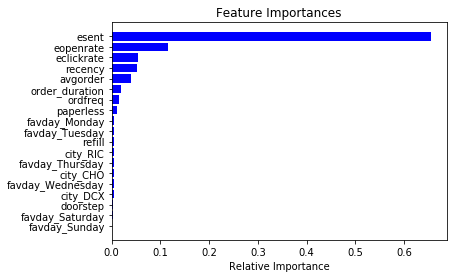

In [182]:
indices = np.argsort(importances)
plt.figure(1)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), X_train.columns[indices])
plt.xlabel('Relative Importance')
plt.savefig('output.png', bbox_inches='tight', dpi = 100, transparent = False)
plt.show()
